# Feedback Prize Effectiveness EDA and DeBERTa baseline

**Before you fork, please give this notebook an upvote 🙂**

Welcome to yet another NLP Kaggle competition! For those of us to enjoy NLP competitions, this is a great time, with 3 NLP competitions occuring simultaneously!

Today I'll walk you through this new competition: **Feedback Prize - Predicting Effective Arguments**

In this competition, we are given a dataset that contains argumentative essays written by U.S students in grades 6-12. As we will see, these essays were annotated by expert raters for _discourse elements_ commonly found in argumentative writing. We are tasked to predict the effectiveness of these discourse elements in the essays. The goal is that such a predictive model can provide automated feedback to students to help them become more confident, proficient writers.

Let's get started with a detailed EDA:

# Imports

In [ ]:
from pathlib import Path
import os

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if not iskaggle:
    import zipfile,kaggle
    path = Path('feedback-prize-effectiveness')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [ ]:
from fastai.imports import *

# Examining the data

Let's see what is available for us to work with for this competition:

In [ ]:
if iskaggle: path = Path('../input/feedback-prize-effectiveness')
path.ls()

We have our standard `train.csv`, `test.csv` and `sample_submission.csv` files along with a `train` and `test` folder.

Let's look at `train.csv` more closely.

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

In [ ]:
len(df)

...and the `test.csv`:

In [ ]:
test_df = pd.read_csv(path/'test.csv')
test_df.head()

In [ ]:
len(test_df)

Let's go through each column and make sure we understand them.

...starting with `discourse_id`. This is just a unique ID for each "discourse" we are classifying. As we can see, the number of unique `discourse_id`s equals the number of rows in our dataset:

In [ ]:
len(df.discourse_id.unique()) == len(df)

Next, let's look at `essay_id`:

In [ ]:
df.essay_id.value_counts()

We can see there are about 4k essays in the dataset, and some essays have many data rows/annotations corresponding to them, while others might only have one!

In [ ]:
df.loc[df.essay_id=='91B1F82B2CF1'].head()

In [ ]:
df.loc[df.essay_id=='DECAE402BB38'].head()

In [ ]:
df.loc[df.essay_id=='9706F8E7D534']

In [ ]:
df.loc[df.essay_id=='5E85F1FB4E22']

Looking at the data more closely, it seems like the essays with more data points have basically been annotated very carefully, with like each sentence of the essay having an annotation. On the other hand, when it only has one annotation, it looks like the whole essay is given one annotation. This should be further analyzed.

Each of the essays are available in full in the folders (`train` for the training set and `test` for the test set).

In [ ]:
len(os.listdir(path/'train')) == len(df.essay_id.unique())

In [ ]:
len(os.listdir(path/'test')) == len(test_df.essay_id.unique())

In [ ]:
essay_len = []
for file in os.listdir(path/'train'):
    with open(path/'train'/file) as f:
        essay_len.append(len(f.read()))

In [ ]:
min(essay_len), np.mean(essay_len), max(essay_len)

In [ ]:
plt.hist(essay_len)

The shortest essay is 691 words long, the longest is 11,641 words long, with a mean of 2315 words. The distribution is long-tailed.

Next, let's look at the `discourse_text`, which is what we are trying to classify.

In [ ]:
text_len = [len(x) for x in df.discourse_text]

In [ ]:
plt.hist(text_len)

In [ ]:
min(text_len), np.mean(text_len), max(text_len)

The length of the text has a minimum of 4 words, an average of ~250 words, but has a long-tailed distribution, with the maximum number of words being 4099. Once again, it seems like maybe there are some full essays that are being given a single annotation.

Let's look at the `discourse_type` column:

In [ ]:
df.discourse_type.value_counts()

There are 7 types of discourse that are being annotated here. The data description for the competition provides more details:

> Lead - an introduction that begins with a statistic, a quotation, a description, or some other device to grab the reader’s attention and point toward the thesis
>
> Position - an opinion or conclusion on the main question
>
> Claim - a claim that supports the position
>
> Counterclaim - a claim that refutes another claim or gives an opposing reason to the position
>
> Rebuttal - a claim that refutes a counterclaim
>
> Evidence - ideas or examples that support claims, counterclaims, or rebuttals.
>
> Concluding Statement - a concluding statement that restates the claims

"Evidence" is the most common type of discourse that is being annotated in this dataset.

Finally, let's look at our target variable that we need to predict, `discourse_effectiveness`:

In [ ]:
df.discourse_effectiveness.value_counts()

There are three options: Ineffective, Effective, and Adequate. The data description provides more info:

>Human readers rated each rhetorical or argumentative element, in order of increasing quality, as one of:
> * Ineffective
> * Adequate
> * Effective

More details on the annotation scheme is provided [here](https://docs.google.com/document/d/1G51Ulb0i-nKCRQSs4p4ujauy4wjAJOae).

In [ ]:
df.loc[df.discourse_effectiveness == 'Effective'].head()

In [ ]:
df.loc[df.discourse_effectiveness == 'Ineffective'].head()

We have looked at all the columns from the training CSV. Remember that `discourse_effectiveness` is not in the test CSV since that is what we are predicting but all the other columns are in there. 

Finally let's look at the `sample_submission.csv` to understand what we need to submit and what our metric is.

In [ ]:
sample_df = pd.read_csv(path/'sample_submission.csv')
sample_df.head()

We effectively just need to submit the logits from our model for each of the classes. These logits are rescaled to sum up to 1 (so like a softmax) by Kaggle and the metric is calculated. The metric used is a log loss:
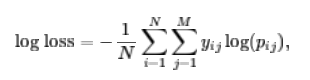

# Training

Here, we'll put together a simple baseline that completely ignores the full essay and only uses the discourse text to make a classification.

Let's import the stuff necessary for training a model. We will be using HuggingFace Transformers to train our model (specifically it's `Trainer` API).

In [ ]:
from torch.utils.data import DataLoader
import warnings,transformers,logging,torch
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification,AutoTokenizer

In [ ]:
if iskaggle:
    !pip install --no-index --find-links ../input/huggingface-datasets datasets -q
import datasets
from datasets import load_dataset, Dataset, DatasetDict

Quiet down some of the warnings produced by HuggingFace Transformers:

In [ ]:
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

DeBERTA v3 Large is a small and simple model good for experimentation. Since we want to submit this notebook, the model is loaded as a dataset so the notebook can stay offline.

In [ ]:
model_nm = '../input/debertav3small'

We now get the tokenizer for our model:

In [ ]:
tokz = AutoTokenizer.from_pretrained(model_nm)

For our baseline, we will concatenate the discourse type and the discourse text and pass to our model. We need to separate the discourse type and the discourse text so that our model knows which is which. We will use the special separator token that the tokenizer has:

In [ ]:
sep = tokz.sep_token
sep

Now let's create the input text:

In [ ]:
df['inputs'] = df.discourse_type + sep +df.discourse_text

HuggingFace expects that the target is in a column to be called `label`, and also that the targets are numerical. We will categorize it and create a new column:

In [ ]:
new_label = {"discourse_effectiveness": {"Ineffective": 0, "Adequate": 1, "Effective": 2}}
df = df.replace(new_label)
df = df.rename(columns = {"discourse_effectiveness": "label"})

Now let's create our `Dataset` object:

In [ ]:
ds = Dataset.from_pandas(df)

To tokenize the data, let's create a function, since that's what `Dataset.map` will need:

In [ ]:
def tok_func(x): return tokz(x["inputs"], truncation=True)

Let's see what one example looks like when tokenized:

In [ ]:
tok_func(ds[0])

We can now tokenize the  the input. We'll use `Dataset.map` to speed it up, and remove the columns we no longer need:

In [ ]:
inps = "discourse_text","discourse_type"
tok_ds = ds.map(tok_func, batched=True, remove_columns=inps+('inputs','discourse_id','essay_id'))

Let's see all the columns:

In [ ]:
tok_ds[0].keys()

Next we need to split the dataset into a training set and a validation set. We will split based on essays:

In [ ]:
essay_ids = df.essay_id.unique()
np.random.seed(42)
np.random.shuffle(essay_ids)
essay_ids[:5]

We'll do a random 80%-20% split:

In [ ]:
val_prop = 0.2
val_sz = int(len(essay_ids)*val_prop)
val_essay_ids = essay_ids[:val_sz]

In [ ]:
is_val = np.isin(df.essay_id, val_essay_ids)
idxs = np.arange(len(df))
val_idxs = idxs[ is_val]
trn_idxs = idxs[~is_val]
len(val_idxs),len(trn_idxs)

We can use the `select` method of the `Dataset` object to create our splits:

In [ ]:
dds = DatasetDict({"train":tok_ds.select(trn_idxs),
             "test": tok_ds.select(val_idxs)})

Here I put all of this into a single function, along with some extra code to deal with the test set (no split necessary):

In [ ]:
def get_dds(df, train=True):
    ds = Dataset.from_pandas(df)
    to_remove = ['discourse_text','discourse_type','inputs','discourse_id','essay_id']
    tok_ds = ds.map(tok_func, batched=True, remove_columns=to_remove)
    if train:
        return DatasetDict({"train":tok_ds.select(trn_idxs), "test": tok_ds.select(val_idxs)})
    else: 
        return tok_ds

We are now ready to train! Let's set some hyperparameters. We select a reasonable LR and a batch size that fits in the GPU RAM. I only train for 1 epoch here.

In [ ]:
lr,bs = 8e-5,16
wd,epochs = 0.01,1

We define our metric. Note that technically our metric is the same as our loss function, but I include it here for clarity and teaching purpose:

In [ ]:
from sklearn.metrics import log_loss
import torch.nn.functional as F
def score(preds): return {'log loss': log_loss(preds.label_ids, F.softmax(torch.Tensor(preds.predictions)))}

Now we can create our model and trainer. HuggingFace uses the `TrainingArguments` class to set up arguments. We'll use a cosine scheduler with warmup. We'll use fp16 since it's much faster on modern GPUs, and saves some memory. We evaluate using double-sized batches, since no gradients are stored so we can do twice as many rows at a time.

In [ ]:
def get_trainer(dds):
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
        evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=wd, report_to='none')
    model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=3)
    return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                   tokenizer=tokz, compute_metrics=score)

Let's train!

In [ ]:
trainer = get_trainer(dds)
trainer.train()

# Inference and Submission

Now we get our test CSV again:

In [ ]:
test_df = pd.read_csv(path/'test.csv')

...and process the same way we did with the training set:

In [ ]:
test_df['inputs'] = test_df.discourse_type + sep + test_df.discourse_text

In [ ]:
test_ds = get_dds(test_df,train=False)

Now we have our `Dataset` object with our test dataset. Then we can simply perform `Trainer.predict` on our dataset to get the predictions.

In [ ]:
preds = F.softmax(torch.Tensor(trainer.predict(test_ds).predictions)).numpy().astype(float)
preds

We put it in a CSV:

In [ ]:
submission_df = pd.read_csv(path/'sample_submission.csv')
submission_df['Ineffective'] = preds[:,0]
submission_df['Adequate'] = preds[:,1]
submission_df['Effective'] = preds[:,2]
submission_df

In [ ]:
submission_df.to_csv('submission.csv',index=False)

... and we are good to go! It's as simple as that! 🙂

# Things to try:

Try different ways of processing and creating our input:
- Include the full essay data (might be tough for some models with limited context length)
- Try different separators, order of dataset

Try different models:
- Bigger models
- Other BERT-like models
- Are there any pretrained models relevant to this dataset available?

Use previous competition data and insights (https://www.kaggle.com/competitions/feedback-prize-2021/)

Hope this helps you get started with this competition!

NOTE: Thie notebook was heavily inspired by Jeremy Howard's [amazing](https://www.kaggle.com/code/jhoward/iterate-like-a-grandmaster) [notebooks](https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners). Be sure to check them out!


**If you found this notebook helpful, please give it an upvote 🙂**